## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [3]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


Copy some of the data-dimensions for convenience.

In [4]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

In [5]:
print(img_size_flat)
print(img_shape)
print(num_classes)

784
(28, 28)
10


In [6]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [7]:
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    #usage of axes in fig, axes
    #https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python
    
    
    for i, ax in enumerate(axes.flat):
        
        #usage of enumerate
        #https://www.geeksforgeeks.org/enumerate-in-python/
        
        # usage of axes.flat
        #https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
        
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #cmap is colormap, it has something to do with the color scheme of the image
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

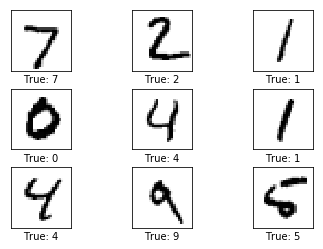

In [9]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.argmax(y_true, axis =1)

In [11]:
hidden1 = 1000
hidden2 = 1000
hidden3 = 500
hidden4 = 200

w1 = tf.Variable(tf.truncated_normal([img_size_flat,hidden1], stddev = 0.05))
h1 = tf.nn.relu(tf.matmul(x,w1))

w2 = tf.Variable(tf.truncated_normal([hidden1,hidden2],stddev = 0.05))
h2 = tf.nn.relu(tf.matmul(h1,w2))

w3 = tf.Variable(tf.truncated_normal([hidden2,hidden3], stddev = 0.05))
h3 = tf.nn.relu(tf.matmul(h2,w3))

w4 = tf.Variable(tf.truncated_normal([hidden3,hidden4],stddev = 0.05))
h4 = tf.nn.relu(tf.matmul(h3,w4))

w5 = tf.Variable(tf.truncated_normal([hidden4,num_classes], stddev = 0.05))
logits = tf.matmul(h4,w5)

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

In [14]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [15]:
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [17]:
batch_size = 100

In [18]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [19]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

In [20]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [21]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.y_test_cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [22]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [23]:
print_accuracy()

Accuracy on test-set: 13.1%


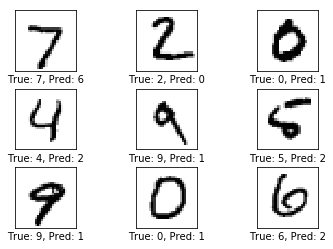

In [24]:
plot_example_errors()

## Performance after 1 optimization iteration

Already after a single optimization iteration, the model has increased its accuracy on the test-set significantly.

In [25]:
optimize(num_iterations=1)

In [26]:
print_accuracy()

Accuracy on test-set: 16.7%


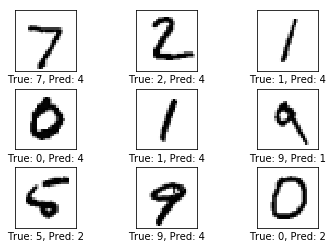

In [27]:
plot_example_errors()

## Performance after 10 optimization iterations

In [28]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [29]:
print_accuracy()

Accuracy on test-set: 45.8%


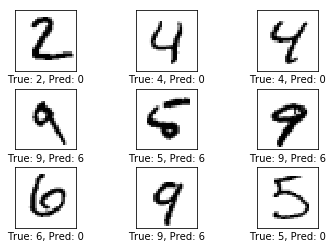

In [30]:
plot_example_errors()

## Performance after 100 optimization iterations

After 100 optimization iterations, the model only mis-classifies about one in ten images. As demonstrated below, some of the mis-classifications are justified because the images are very hard to determine with certainty even for humans, while others are quite obvious and should have been classified correctly by a good model. But this simple model cannot reach much better performance and more complex models are therefore needed.

In [31]:
# We have already performed 10 iterations.
optimize(num_iterations=90)

In [32]:
print_accuracy()

Accuracy on test-set: 89.1%


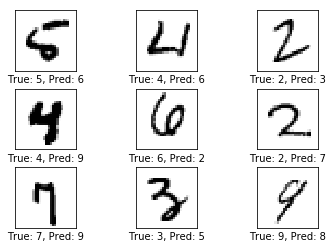

In [33]:
plot_example_errors()

[[ 959    0    1    2    0    4    8    1    5    0]
 [   0 1113    0    6    1    0    4    1    9    1]
 [  17   10  873   37   16    2   16   11   46    4]
 [   9    0   11  895    0   37    0   10   24   24]
 [   1    2    6    0  857    0   11    0    8   97]
 [  39    3    6   46    9  698   11    5   38   37]
 [  27    3    5    0   16   22  873    0   12    0]
 [   4   13   23    4    9    0    0  878    8   89]
 [  10    5    5   35    7   23    8    2  825   54]
 [   7    4    6   11   22    8    1    5   10  935]]


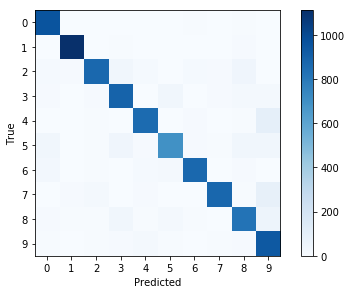

In [34]:
print_confusion_matrix()

In [69]:
w1 = np.ndarray.flatten(np.asarray(session.run(w1)))
w2 = np.ndarray.flatten(np.asarray(session.run(w2)))
w3 = np.ndarray.flatten(np.asarray(session.run(w3)))
w4 = np.ndarray.flatten(np.asarray(session.run(w4)))
w5 = np.asarray(session.run(w5))

In [70]:
w3

array([-0.03429949,  0.        ,  0.        , ...,  0.04201496,
        0.        ,  0.02306279], dtype=float32)

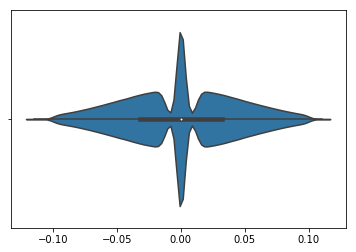

In [71]:
sns.violinplot(w3)

In [72]:
# set percentage sparsity

k = 50

In [73]:
w1[np.abs(w1)<np.percentile(np.abs(w1),k)] = 0
w1 = w1.reshape([img_size_flat,hidden1])

w2[np.abs(w2)<np.percentile(np.abs(w2),k)] = 0
w2 = w2.reshape([hidden1,hidden2])

w3[np.abs(w3)<np.percentile(np.abs(w3),k)] = 0
w3 = w3.reshape([hidden2,hidden3])

w4[np.abs(w4)<np.percentile(np.abs(w4),k)] = 0
w4 = w4.reshape([hidden3,hidden4])

In [74]:
w3

array([[-0.03429949,  0.        ,  0.        , ...,  0.        ,
         0.04490719, -0.07006971],
       [ 0.        ,  0.04356858,  0.09871513, ...,  0.        ,
        -0.05772604,  0.08155151],
       [ 0.        ,  0.        , -0.05558975, ...,  0.0850631 ,
         0.        ,  0.        ],
       ...,
       [-0.09275375,  0.        ,  0.        , ..., -0.07790338,
        -0.05929184,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0844624 ,
        -0.0468679 ,  0.07505935],
       [ 0.        ,  0.        ,  0.07949328, ...,  0.04201496,
         0.        ,  0.        ]], dtype=float32)

In [75]:
w1 = tf.convert_to_tensor(w1)
w2 = tf.convert_to_tensor(w2)
w3 = tf.convert_to_tensor(w3)
w4 = tf.convert_to_tensor(w4)

In [76]:
print(w1.shape)
print(w2.shape)
print(w3.shape)
print(w4.shape)

(784, 1000)
(1000, 1000)
(1000, 500)
(500, 200)


In [77]:
type(w1)

tensorflow.python.framework.ops.Tensor

In [78]:
w1 = tf.Variable(w1)
h1 = tf.nn.relu(tf.matmul(x,w1))

w2 = tf.Variable(w2)
h2 = tf.nn.relu(tf.matmul(h1,w2))

w3 = tf.Variable(w3)
h3 = tf.nn.relu(tf.matmul(h2,w3))

w4 = tf.Variable(w4)
h4 = tf.nn.relu(tf.matmul(h3,w4))

w5 = tf.Variable(w5)
logits = tf.matmul(h4,w5)

In [79]:
y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

In [80]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [81]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [82]:
session.run(w3)

array([[-0.03429949,  0.        ,  0.        , ...,  0.        ,
         0.04490719, -0.07006971],
       [ 0.        ,  0.04356858,  0.09871513, ...,  0.        ,
        -0.05772604,  0.08155151],
       [ 0.        ,  0.        , -0.05558975, ...,  0.0850631 ,
         0.        ,  0.        ],
       ...,
       [-0.09275375,  0.        ,  0.        , ..., -0.07790338,
        -0.05929184,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0844624 ,
        -0.0468679 ,  0.07505935],
       [ 0.        ,  0.        ,  0.07949328, ...,  0.04201496,
         0.        ,  0.        ]], dtype=float32)

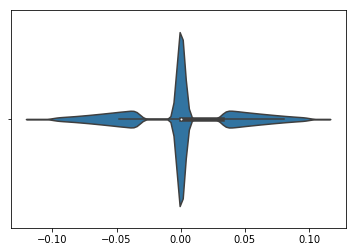

In [83]:
sns.violinplot(session.run(w3))

In [84]:
print_accuracy()

Accuracy on test-set: 87.7%
